In [102]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

Dim. of X-data: 400 x 2
Mean p: 
[ 0.4075  0.3625  0.505   0.38    0.495   0.3725  0.4575  0.4575  0.42
  0.3775  0.535   0.46    0.6725  0.5     0.425   0.55    0.4075  0.4275
  0.5525  0.41    0.39    0.6125  0.5275  0.4875  0.47    0.5775  0.485
  0.375   0.4125  0.53    0.245   0.36    0.4725  0.5425  0.395   0.4575
  0.5575  0.4575  0.38    0.6225  0.47    0.6425  0.4425  0.475   0.4425
  0.5375  0.4875  0.4175  0.3775  0.4875  0.69    0.59    0.495   0.55
  0.52    0.3775  0.4975  0.5125  0.6125  0.43    0.6225  0.51    0.3225
  0.3575  0.4725  0.675   0.5125  0.375   0.38    0.4075  0.4325  0.5275
  0.6225  0.485   0.49    0.3775  0.455   0.445   0.585   0.445   0.37
  0.65    0.5     0.5975  0.4725  0.5475  0.645   0.4375  0.6475  0.51
  0.57    0.4675  0.5625  0.5425  0.445   0.43    0.4975  0.625   0.415
  0.41  ]
Dim. of Y-data: 400 x 100
Assumed f-mean:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

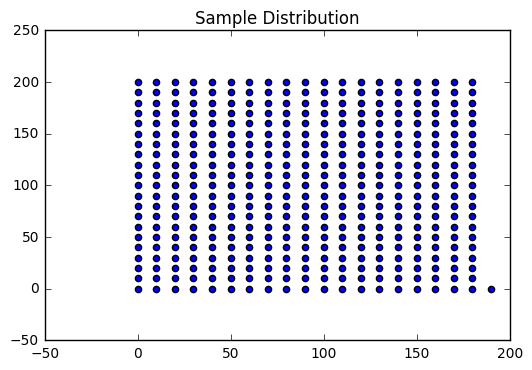

In [103]:
nr_inds=101
X_data = np.loadtxt('./coordinates6.csv', delimiter='$').astype('float64')[:400,:] # Only load first nr_inds entries
#X_data /= np.max(X_data)    # Divide by the maximum WHY??
Y_data = np.loadtxt('./data_genotypes6.csv', delimiter='$').astype('float64')[:400,:]



#print(mean_f)

#./data_genotypes5.csv has mean p=0.2

assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean=np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("Mean p: ")
print(p_mean)

# Change this for coordinates5.csv  (If mean is known)
f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mean_paramss)

# Plot the data
pylab.figure()
pylab.title("Sample Distribution")
pylab.scatter(X_data[:,0], X_data[:,1])
pylab.show()

In [104]:
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad

In [105]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    kernel_params = tf.placeholder(shape=[2], dtype=tf.float64)      # HyperParameters for the Kernel
    mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    l = kernel_params[1]
    a = kernel_params[0]
    mean_param = mean_params
    
    eye = tf.eye(N)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
        0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       # 0.0001 * eye                

    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = tf.nn.sigmoid(f_tot)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * f_tot)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calcualte 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessia. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    
    ##### Gradients and Hessian #######################3
    
    grad = tf.gradients(margL, kernel_params)
    hessian = tf.hessians(margL, kernel_params)

In [106]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [89]:
### Single Run
aa, ll = 0.1, 25
kk = np.array([0.1, 25])


with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    #r = sess.run([opt_op, update, logL, margL], {a: aa, l: ll})
    r = sess.run([opt_op, update, logL, margL], {kernel_params: kk, mean_param: mean_paramss})
    print(r[-1])    # Print marginal Likelihood

-11529509.889


In [107]:
a_list = np.logspace(-1.5, -0.5, 10)   # Original Values
l_list = np.logspace(1, 2, 10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)


print(a_list)
print(l_list)
print(len(mean_paramss))

[ 0.03162278  0.04084239  0.05274997  0.06812921  0.08799225  0.11364637
  0.14677993  0.18957357  0.24484367  0.31622777]
[  10.           12.91549665   16.68100537   21.5443469    27.82559402
   35.93813664   46.41588834   59.94842503   77.42636827  100.        ]
100


In [108]:
res = []
j=0
with tf.Session(config=config) as sess:
    for aa in a_list:
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                r = sess.run([opt_op, update, logL, margL], {a: aa, l:ll, mean_param: mean_paramss})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Likelihood: %4f" % r[-1])
            res.append(r[-1])

Doing run: 0
Tested a: 0.031623
Tested l: 10.000000
Likelihood: -27692.411760
Doing run: 1
Tested a: 0.031623
Tested l: 12.915497
Likelihood: -27670.828287
Doing run: 2
Tested a: 0.031623
Tested l: 16.681005
Likelihood: -27641.131741
Doing run: 3
Tested a: 0.031623
Tested l: 21.544347
Likelihood: -27603.118794
Doing run: 4
Tested a: 0.031623
Tested l: 27.825594
Likelihood: -27558.420386
Doing run: 5
Tested a: 0.031623
Tested l: 35.938137
Likelihood: -27509.954232
Doing run: 6
Tested a: 0.031623
Tested l: 46.415888
Likelihood: -27460.856350
Doing run: 7
Tested a: 0.031623
Tested l: 59.948425
Likelihood: -27414.276122
Doing run: 8
Tested a: 0.031623
Tested l: 77.426368
Likelihood: -27373.987404
Doing run: 9
Tested a: 0.031623
Tested l: 100.000000
Likelihood: -27343.354182
Doing run: 10
Tested a: 0.040842
Tested l: 10.000000
Likelihood: -27683.872278
Doing run: 11
Tested a: 0.040842
Tested l: 12.915497
Likelihood: -27657.204476
Doing run: 12
Tested a: 0.040842
Tested l: 16.681005
Likeliho

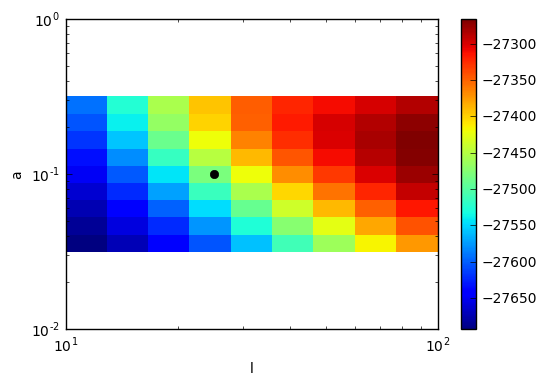

In [109]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, a_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
pylab.plot(25, 0.1, 'ko', linewidth=5)

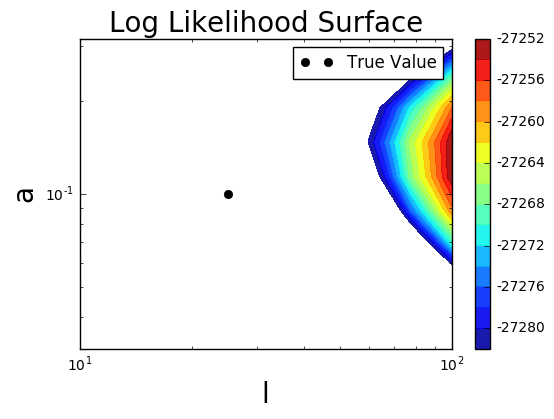

In [110]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
pylab.colorbar(ax, format="%i")
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("l", fontsize=20)
pylab.ylabel("a", fontsize=20)
pylab.xscale('log')
pylab.yscale('log')
pylab.plot(25, 0.1, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.show()

In [17]:
aa, ll = 0.1, 25
kk = np.array([0.1, 25])

In [18]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {kernel_params: kk, mean_param: mean_paramss})
    r = sess.run([F, margL], {kernel_params: kk, mean_param: mean_paramss})
    print(r[-1])   # Prints the Marginal Likelihood

-6914.353692


In [94]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

101
101
101


IndexError: too many indices for array

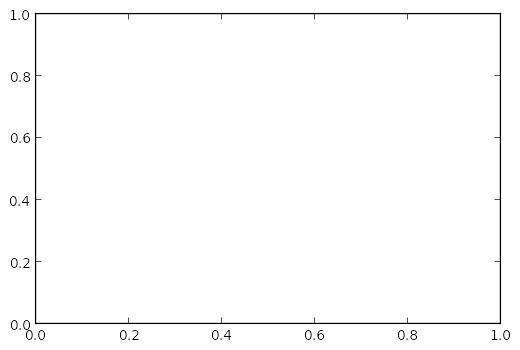

In [95]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
961 ** 0.5

In [ ]:
with tf.Session() as sess:
    r = sess.run(tf.diag(tf.ones(5)))

In [ ]:
r

In [ ]:
tf.__version__

In [ ]:
logdet

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [12]:
r

21396.780081331875